<a href="https://colab.research.google.com/github/BinaryBeast-007/AI_for_Network_Security/blob/main/Variational_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


In [2]:
# Load the dataset (Make sure to adjust the path accordingly)
# dataset_path = "/content/KDDTrain+_20Percent.txt"
dataset_path = "/content/KDDTrain+.txt"
column_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
                "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
                "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
                "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
                "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
                "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv(dataset_path, header=None, names=column_names)

In [3]:
df['label'] = df['dst_host_srv_rerror_rate'].apply(lambda x: 0 if x != 'normal' else 1)
df = df.drop(["duration", "protocol_type", "service", "dst_host_srv_rerror_rate"], axis=1)
X = df.drop('label', axis=1)
y = df['label']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Define VAE architecture
input_dim = X_train.shape[1]
latent_dim = 5  # Reduced latent dimension

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

inputs = Input(shape=(input_dim,))
h = Dense(128, activation='relu')(inputs)
h = Dropout(0.5)(h)
h = BatchNormalization()(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z])

In [5]:
# Decoder architecture
decoder_h = Dense(128, activation='relu')
decoder_out = Dense(input_dim, activation='sigmoid')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_out(h_decoded)

vae = Model(inputs, x_decoded_mean)

xent_loss = input_dim * K.mean(K.binary_crossentropy(inputs, x_decoded_mean), axis=-1)
kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = xent_loss + kl_loss

vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=0.0001))  # Adjusted learning rate

In [6]:
# Train the VAE
vae.fit(X_train, epochs=10, batch_size=32, validation_data=(X_test, None))

Epoch 1/10
2247/2247 [==============================] - 22s 8ms/step - loss: -7729151.0000 - val_loss: nan
Epoch 2/10
2247/2247 [==============================] - 14s 6ms/step - loss: -85002800.0000 - val_loss: nan
Epoch 3/10
2247/2247 [==============================] - 9s 4ms/step - loss: -163219696.0000 - val_loss: nan
Epoch 4/10
2247/2247 [==============================] - 9s 4ms/step - loss: -559002112.0000 - val_loss: nan
Epoch 5/10
2247/2247 [==============================] - 9s 4ms/step - loss: -1288827776.0000 - val_loss: nan
Epoch 6/10
2247/2247 [==============================] - 10s 4ms/step - loss: -2170940928.0000 - val_loss: nan
Epoch 7/10
2247/2247 [==============================] - 8s 3ms/step - loss: -3521970688.0000 - val_loss: nan
Epoch 8/10
2247/2247 [==============================] - 10s 4ms/step - loss: -5445733888.0000 - val_loss: nan
Epoch 9/10
2247/2247 [==============================] - 9s 4ms/step - loss: -3880756992.0000 - val_loss: nan
Epoch 10/10
2247/2247 

In [7]:
# Use encoder to get latent representation of the data
encoded_X_train, _, _ = encoder.predict(X_train)
encoded_X_test, _, _ = encoder.predict(X_test)

562/562 [==============================] - 1s 2ms/step


In [8]:
# Use the encoded data in your anomaly detection model (you can use a simple classifier on top of the encoded data)
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(latent_dim,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
model.fit(encoded_X_train, y_train, epochs=10, batch_size=32, validation_data=(encoded_X_test, y_test))

Epoch 1/10
2247/2247 [==============================] - 6s 3ms/step - loss: 30.3230 - accuracy: 0.8589 - val_loss: nan - val_accuracy: 0.9042
Epoch 2/10
2247/2247 [==============================] - 8s 4ms/step - loss: 1.4554 - accuracy: 0.8940 - val_loss: nan - val_accuracy: 0.9025
Epoch 3/10
2247/2247 [==============================] - 5s 2ms/step - loss: 0.9563 - accuracy: 0.8943 - val_loss: nan - val_accuracy: 0.9015
Epoch 4/10
2247/2247 [==============================] - 8s 3ms/step - loss: 0.6327 - accuracy: 0.8952 - val_loss: nan - val_accuracy: 0.9014
Epoch 5/10
2247/2247 [==============================] - 5s 2ms/step - loss: 0.4365 - accuracy: 0.8975 - val_loss: nan - val_accuracy: 0.8909
Epoch 6/10
2247/2247 [==============================] - 7s 3ms/step - loss: 0.3486 - accuracy: 0.8983 - val_loss: nan - val_accuracy: 0.9022
Epoch 7/10
2247/2247 [==============================] - 6s 3ms/step - loss: 0.3656 - accuracy: 0.8978 - val_loss: nan - val_accuracy: 0.9014
Epoch 8/10
2

In [11]:
# Evaluate the model
y_pred = model.predict(encoded_X_test)

562/562 [==============================] - 1s 1ms/step


In [12]:
y_pred

array([[0.8782277],
       [0.8782277],
       [0.8782277],
       ...,
       [0.8782278],
       [0.8782278],
       [0.8782278]], dtype=float32)

In [13]:
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.81      0.88      8382
           1       0.85      0.98      0.91      9590

    accuracy                           0.90     17972
   macro avg       0.92      0.90      0.90     17972
weighted avg       0.91      0.90      0.90     17972



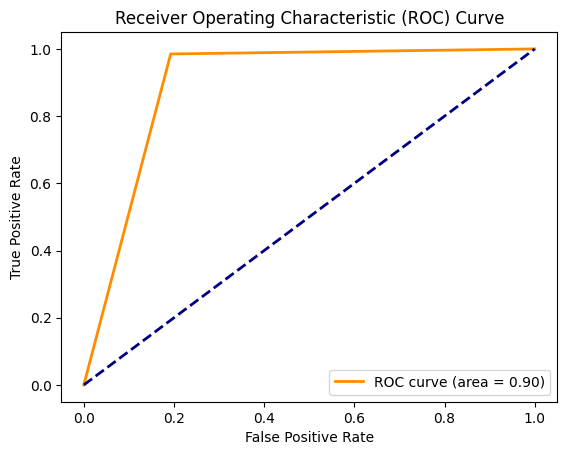

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [15]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9021255286000445


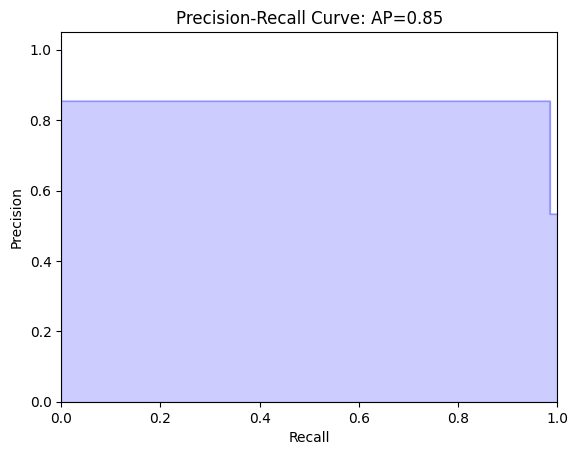

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.2f}'.format(average_precision))
plt.show()


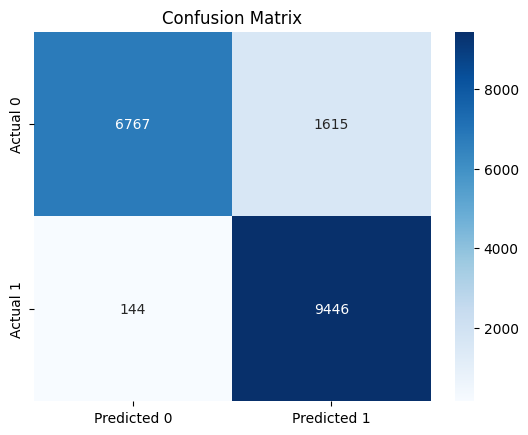

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.show()


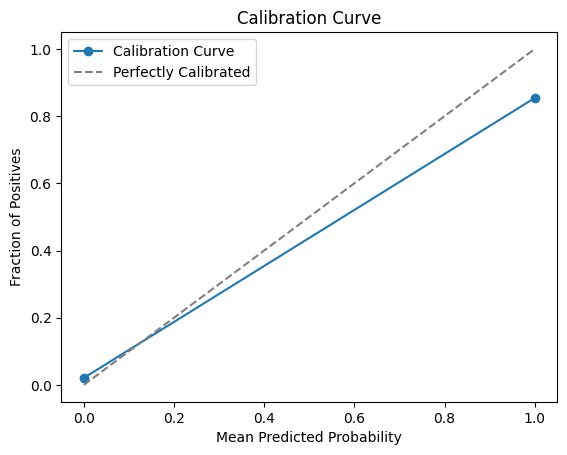

In [18]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()
